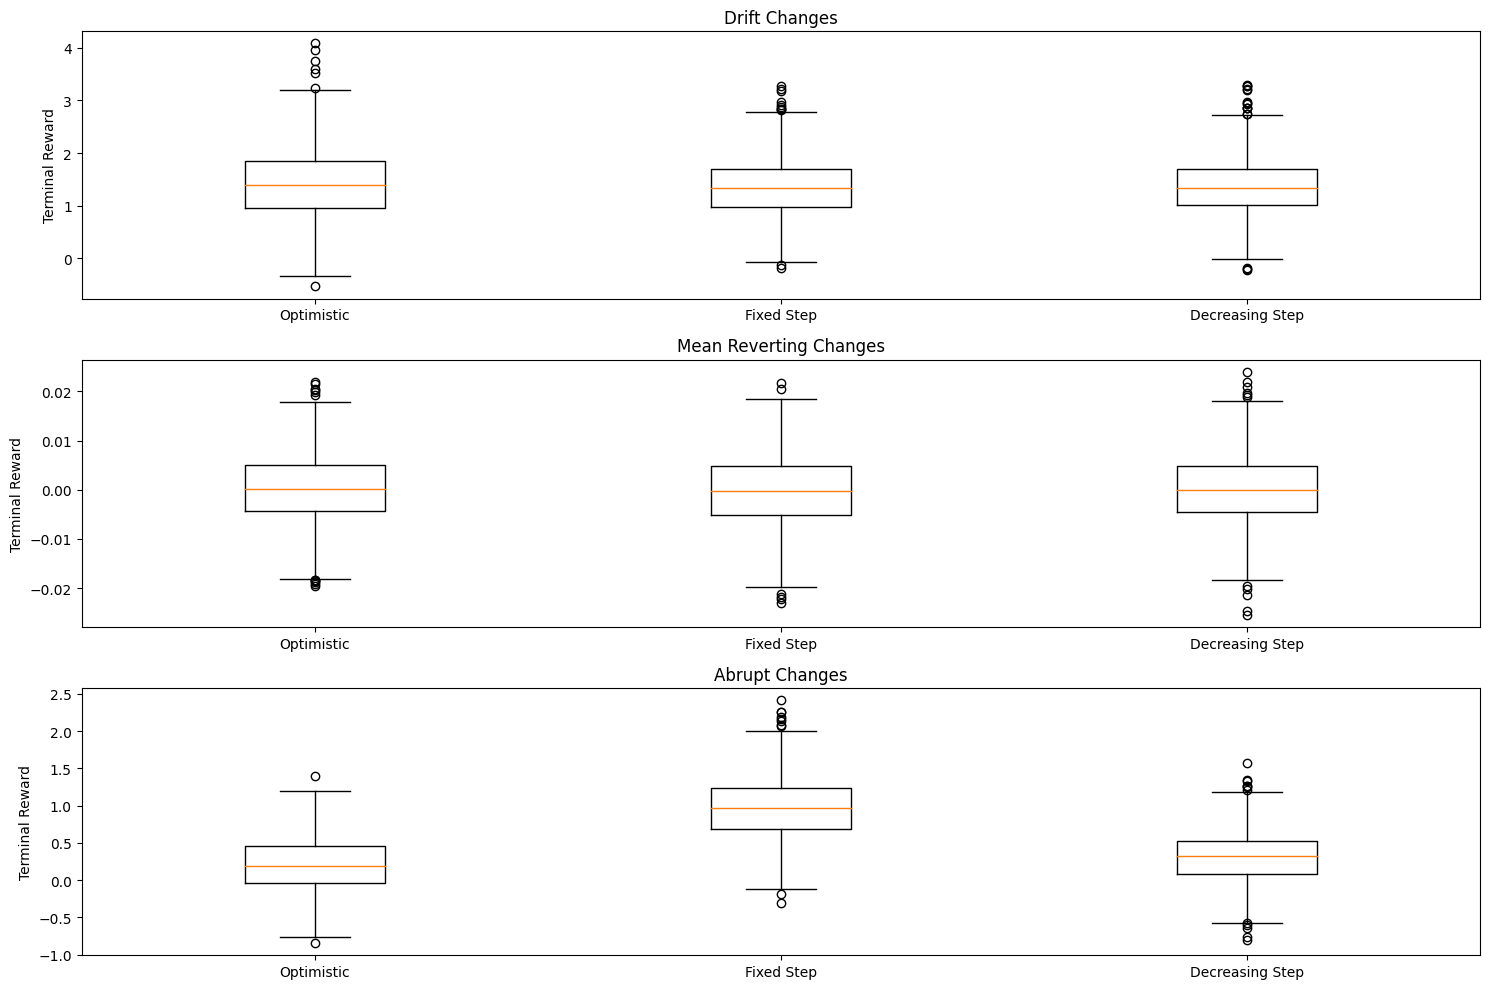

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NonStationaryBandit:
    def __init__(self, k, epsilon=None, alpha=None, optimistic_initial_values=0, mode="drift"):
        self.k = k
        self.epsilon = epsilon if epsilon is not None else 0
        self.alpha = alpha if alpha is not None else 0
        self.optimistic_initial_values = optimistic_initial_values
        self.qstar = np.random.normal(0, 1, k)
        self.qestimates = np.zeros(k) + optimistic_initial_values
        self.actioncounts = np.zeros(k)
        self.total_reward = 0
        self.optimal_action_count = 0
        self.mode = mode

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.k)
        else:
            return np.argmax(self.qestimates)

    def update_values(self, action, reward):
        self.actioncounts[action] += 1
        self.total_reward += reward
        if self.alpha == 0:  # Simple average method
            self.qestimates[action] += (reward - self.qestimates[action]) / self.actioncounts[action]
        else:  # Constant step size
            self.qestimates[action] += self.alpha * (reward - self.qestimates[action])
        if action == np.argmax(self.qstar):
            self.optimal_action_count += 1

    def update_qstar(self):
        if self.mode == "drift":
            self.qstar += np.random.normal(0, 0.001, self.k)
        elif self.mode == "mean_reverting":
            self.qstar = 0.5 * self.qstar + np.random.normal(0, 0.01, self.k)
        elif self.mode == "abrupt":
            if np.random.rand() < 0.005:
                np.random.shuffle(self.qstar)

    def run_bandit(self, steps):
        rewards = []
        optimal_actions = []
        for step in range(steps):
            action = self.choose_action()
            reward = np.random.normal(self.qstar[action], 1)
            self.update_values(action, reward)
            self.update_qstar()
            rewards.append(self.total_reward / (step + 1))
            optimal_actions.append(self.optimal_action_count / (step + 1))
        return rewards, optimal_actions

def run_experiment(method, mode, k=10, num_bandit_problems=1000, steps=10000, **kwargs):
    terminal_rewards = np.zeros(num_bandit_problems)
    for i in range(num_bandit_problems):
        bandit = NonStationaryBandit(k, mode=mode, **kwargs)
        rewards, _ = bandit.run_bandit(steps)
        terminal_rewards[i] = rewards[-1]
    return terminal_rewards



# Set up the experiments
k = 10
num_bandit_problems = 1000
steps = 20000

# Optimistic Greedy
optimistic_terminal_rewards_drift = run_experiment("greedy", "drift", k, num_bandit_problems, steps, epsilon=0, optimistic_initial_values=5.0)
optimistic_terminal_rewards_mean_reverting = run_experiment("greedy", "mean_reverting", k, num_bandit_problems, steps, epsilon=0, optimistic_initial_values=5.0)
optimistic_terminal_rewards_abrupt = run_experiment("greedy", "abrupt", k, num_bandit_problems, steps, epsilon=0, optimistic_initial_values=5.0)

# Epsilon-Greedy with Fixed Step Size
fixed_step_rewards_drift = run_experiment("epsilon-greedy", "drift", k, num_bandit_problems, steps, epsilon=0.1, alpha=0.1)
fixed_step_rewards_mean_reverting = run_experiment("epsilon-greedy", "mean_reverting", k, num_bandit_problems, steps, epsilon=0.1, alpha=0.1)
fixed_step_rewards_abrupt = run_experiment("epsilon-greedy", "abrupt", k, num_bandit_problems, steps, epsilon=0.1, alpha=0.1)

# Epsilon-Greedy with Decreasing Step Size (simple average)
decreasing_step_rewards_drift = run_experiment("epsilon-greedy", "drift", k, num_bandit_problems, steps, epsilon=0.1, alpha=0)
decreasing_step_rewards_mean_reverting = run_experiment("epsilon-greedy", "mean_reverting", k, num_bandit_problems, steps, epsilon=0.1, alpha=0)
decreasing_step_rewards_abrupt = run_experiment("epsilon-greedy", "abrupt", k, num_bandit_problems, steps, epsilon=0.1, alpha=0)

# Box plots
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.boxplot([optimistic_terminal_rewards_drift, fixed_step_rewards_drift, decreasing_step_rewards_drift], labels=['Optimistic', 'Fixed Step', 'Decreasing Step'])
plt.title('Drift Changes')
plt.ylabel('Terminal Reward')

plt.subplot(3, 1, 2)
plt.boxplot([optimistic_terminal_rewards_mean_reverting, fixed_step_rewards_mean_reverting, decreasing_step_rewards_mean_reverting], labels=['Optimistic', 'Fixed Step', 'Decreasing Step'])
plt.title('Mean Reverting Changes')
plt.ylabel('Terminal Reward')

plt.subplot(3, 1, 3)
plt.boxplot([optimistic_terminal_rewards_abrupt, fixed_step_rewards_abrupt, decreasing_step_rewards_abrupt], labels=['Optimistic', 'Fixed Step', 'Decreasing Step'])
plt.title('Abrupt Changes')
plt.ylabel('Terminal Reward')

plt.tight_layout()
plt.show()
